
# - 공공자전거 분석
1. 뉴스크롤링/워드클라우드
2. 데이터 파일(대여파일, 고장파일) 로드, 기본 통계량 확인(메모리 제한으로 5,6월)
3. 자전거 대여관련 평균 확인(평균이용시간, 평균이동거리, 평균대여건수)
4. 그래프 전시
   - 이용시간, 이용거리 현황 파악
   - 일자별 대여건수
5. 이상치 분석
   - 누적거리가 0인 경우(고장이나 기타 다른 이유로 사용이 안되는 상태)
   - 이용거리가 0인 경우 발생(장비 오류가 간헐적으로 발생하는 경우로 보고 다음달 고장상태가 될 것으로 가정)
6. 지도 전시
   - 특정 대여 대여소 출발, 반납 대여소 지도 전시
   - 누적거리가 가장 긴 자전거 경로 표시
7. 제안사항
    - led 부착으로 점검상태 표시(사용자 및 관리자 자전거 상태 및 점검 상태 확인 가능)

!pip install xlwt

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, '한글 타이틀...')

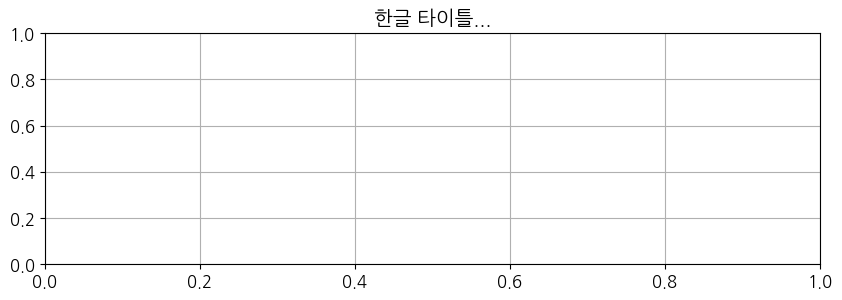

In [2]:
import matplotlib.font_manager as fm

# 전역 폰트 설정 사용
font_path = 'C:/Windows/Fonts/NanumGothic.ttf'
#font_path = 'C:/Windows/Fonts/malgun.ttf'
# font_path = '/Users/qkboo/Library/Fonts/NanumGothic.otf'
#font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

fontname = fm.FontProperties(fname=font_path, size=18).get_name()  # 폰트 패밀리 이름!
# plt.rc('font', family=fontname)
plt.rcParams["font.family"] = fontname
plt.rcParams["font.size"] = 12

# matplotlib 설정
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10,3)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000

plt.title('한글 타이틀...')

# ㅇ 관련 뉴스 검색-불용어처리, 최빈단어 워드클라우드

In [3]:
import requests
from bs4 import BeautifulSoup

def news_search(s_word:str, n_sort:int):
    title_s = ''
    for x in range(1,20):
        url = r'https://search.naver.com/search.naver?where=news&sm=tab_pge&query={}&sort={}&photo=0&field=0&pd=0&ds=&de=&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:dd,p:all,a:all&start={}'.format(s_word, n_sort, 10*(x-1)+1)
        resp = requests.get(url)
        soup = BeautifulSoup(resp.text, 'lxml')
        title_li = soup.find_all('a', class_ = 'news_tit')

        for i in title_li:
            title_s += i.get_text()
    return title_s

if __name__ == '__main__':
    return_ = news_search('따릉이', 1) # 관련도순: 0, 최신순: 1, 오래된 순: 2

In [8]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from konlpy.tag import Hannanum
import pandas as pd
hannanum = Hannanum()
return_list = hannanum.nouns(return_)
stop_words = ["허 참 세상일도", "내면서", "것이다", "잘해주이소", "평화", "북한", "장소","주유소"] #사용하지 않을 단어 또는 문장 추가
line = [i for i in return_list if i not in stop_words]
news_tokens = [word for word in line if len(word) > 1] # 1글자 제외

In [9]:
word_list = pd.Series(news_tokens)
result = word_list.value_counts().head(30)

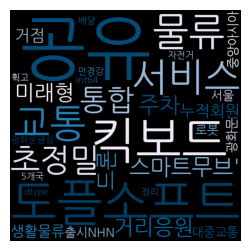

In [10]:
wc = WordCloud(font_path="./NanumGothic.ttf", colormap="PuBu", width=800, height=800 )
wc.generate(str(result))
plt.imshow(wc)                 
plt.axis("off")               
plt.show()

# 월별 대여 자료로드 및 병합(메모리 제한으로 5, 6월 자료 활용)

In [11]:
df_2022 = pd.DataFrame()

for i in range(5, 7):
    path = 'data/서울특별시 공공자전거 대여이력 정보_22.0%d.csv' %i
    temp = pd.read_csv(path, encoding='ansi')
    df_2022 = pd.concat([df_2022, temp])

In [12]:
df_2022.shape

(9130645, 11)

In [16]:
df_2022['평균속도']=round(df_2022['이용거리']/df_2022['이용시간'],1) # 평균속도 컬럼 추가

In [17]:
df_2022.describe()

,대여 대여소번호,대여거치대,반납대여소번호,반납거치대,이용시간,이용거리,평균속도
count,9.130645e+06,9.130645e+06,9.130645e+06,9.130645e+06,9.130645e+06,9.130645e+06,9128471.0
mean,1.947330e+03,4.050711e+00,1.949460e+03,4.042092e+00,2.347633e+01,2.835530e+03,inf
std,1.442552e+03,1.961153e+01,1.436683e+03,1.959154e+01,2.706257e+01,3.398220e+03,NaN
min,3.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,7.640000e+02,0.000000e+00,7.680000e+02,0.000000e+00,7.000000e+00,9.255000e+02,103.8
50%,1.601000e+03,0.000000e+00,1.601000e+03,0.000000e+00,1.300000e+01,1.670000e+03,143.6
75%,2.823000e+03,0.000000e+00,2.824000e+03,0.000000e+00,3.000000e+01,3.299930e+03,181.0
max,9.999900e+04,9.900000e+01,9.999900e+04,9.900000e+01,1.612000e+03,1.722972e+05,inf


# 이용시간 0, 이용시간 5분 이내, 이용시간 200분이상(대여 현황 파악)

In [18]:
df_2022[df_2022['이용시간']==0].count(), df_2022[df_2022['이용시간']<5].count(), df_2022[df_2022['이용시간']>200].count()

(자전거번호       4230
 대여일시        4230
 대여 대여소번호    4230
 대여 대여소명     4230
 대여거치대       4230
 반납일시        4230
 반납대여소번호     4230
 반납대여소명      4230
 반납거치대       4230
 이용시간        4230
 이용거리        4230
 평균속도        2056
 dtype: int64,
 자전거번호       1181449
 대여일시        1181449
 대여 대여소번호    1181449
 대여 대여소명     1181449
 대여거치대       1181449
 반납일시        1181449
 반납대여소번호     1181449
 반납대여소명      1181449
 반납거치대       1181449
 이용시간        1181449
 이용거리        1181449
 평균속도        1179275
 dtype: int64,
 자전거번호       9129
 대여일시        9129
 대여 대여소번호    9129
 대여 대여소명     9129
 대여거치대       9129
 반납일시        9129
 반납대여소번호     9129
 반납대여소명      9129
 반납거치대       9129
 이용시간        9129
 이용거리        9129
 평균속도        9129
 dtype: int64)

In [19]:
# 평균이동거리
df_mean_dis = df_2022['이용거리'].mean()
df_mean_time = df_2022['이용시간'].mean()
df_mean_lent = len(df_2022)/30
print("평균이동거리:%.2f, 평균이용시간:%d,일일평균대여횟수:%d"%(df_mean_dis, df_mean_time, df_mean_lent))

평균이동거리:2835.53, 평균이용시간:23,일일평균대여횟수:304354


# ㅇ 고장신고 내역

In [30]:
# 고장신고 내역 로드
df_out = pd.read_csv('data/고장신고 내역_22.01-06.csv', encoding='euc-kr')
df_out.columns = ['자전거번호', '대여일시', '고장구분']
df_out

,자전거번호,대여일시,고장구분
0,SPB-36049,2022-01-01 0:45,기타
1,SPB-34190,2022-01-01 1:01,기타
2,SPB-39295,2022-01-01 1:08,체인
3,SPB-32092,2022-01-01 1:55,기타
4,SPB-31554,2022-01-01 2:01,체인
...,...,...,...
74919,SPB-56997,2022-06-29 21:18,타이어
74920,SPB-53871,2022-06-29 22:02,체인
74921,SPB-57521,2022-06-29 22:04,안장
74922,SPB-60598,2022-06-29 22:28,단말기


# ㅇ 그래프- heatmap 으로 항목간 상관관계 파악
## - 대여 대여소-반납대여소간 상관관계 확인 

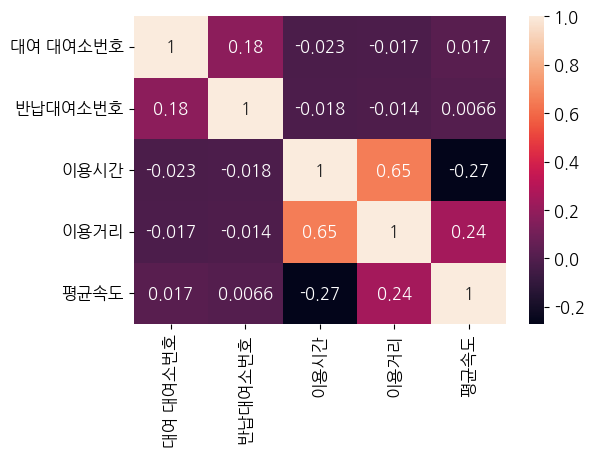

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_2022[['대여 대여소번호', '반납대여소번호', '이용시간', '이용거리', '평균속도']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True)
plt.show()

In [21]:
print("최소이용시간:",df_2022['이용시간'].min(), "최대이용시간:",df_2022['이용시간'].max())
print("최소이동거리:",df_2022['이용거리'].min(), "최대이용거리:",df_2022['이용거리'].max())

최소이용시간: 0 최대이용시간: 1612
최소이동거리: 0.0 최대이용거리: 172297.16


# ㅇ histogram으로 이용시간, 이용거리 특성 파악

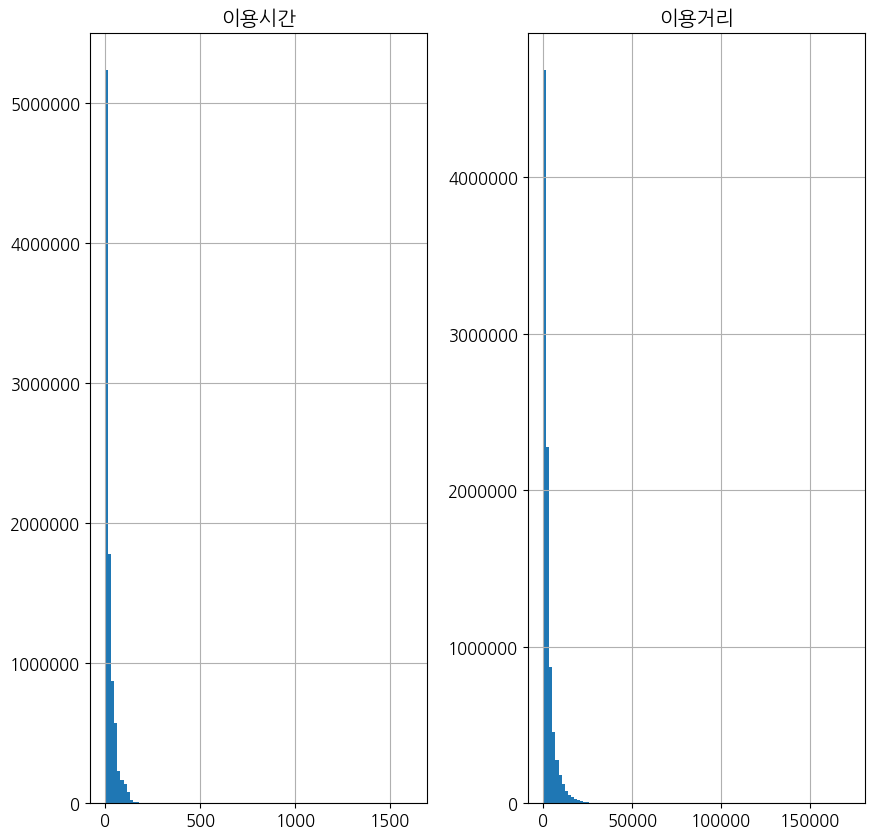

In [22]:
new_df=df_2022[['이용시간', '이용거리']]
new_df.hist(bins=100, figsize=(10, 10))
plt.show()

# ㅇ 일자별 대여건수

In [23]:
import datetime
new_df = df_2022[['대여일시', '이용시간']]
new_df['대여일시'] = pd.to_datetime(new_df['대여일시'], format='%Y-%m-%d')

C:\Users\user\AppData\Local\Temp\ipykernel_21064\2885408834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['대여일시'] = pd.to_datetime(new_df['대여일시'], format='%Y-%m-%d')


In [24]:
df_per_date = df_2022.groupby(new_df['대여일시'].dt.day).agg({'이용시간': 'count'})

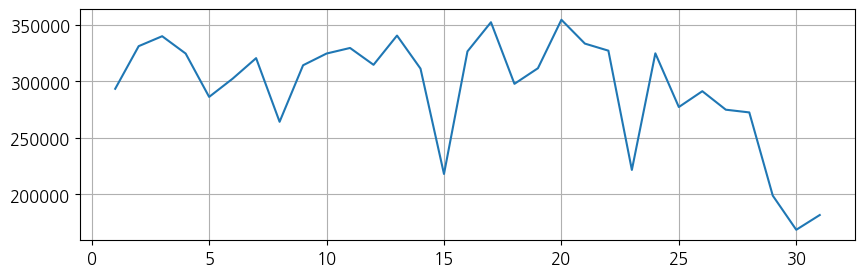

In [25]:
plt.plot(df_per_date)

In [26]:
df_2022['자전거번호'].nunique() # 전체 자전거 수

35794

In [32]:
df_out['자전거번호'].nunique() # 고장신고 자전거 수

26214

In [33]:
df_2022.columns

Index(['자전거번호', '대여일시', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납대여소번호',
       '반납대여소명', '반납거치대', '이용시간', '이용거리', '평균속도'],
      dtype='object')

# ㅇ 고장 자전거별 고장횟수(22년 1월 ~ 6월)

In [34]:
df_out_n = df_out.groupby(['자전거번호']).agg({'고장구분': 'count'})
df_out_n.shape 

(26214, 1)

<AxesSubplot: xlabel='자전거번호'>

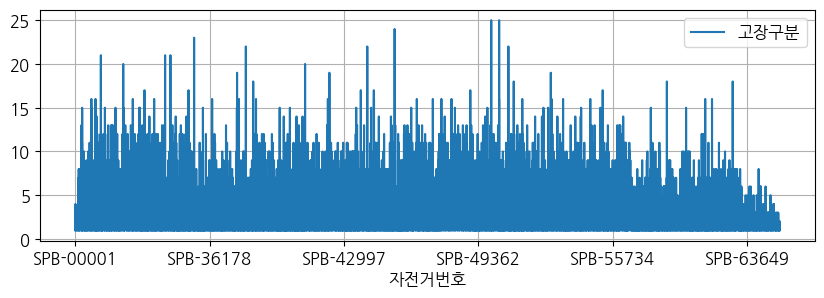

In [35]:
df_out_n.plot()

In [36]:
df_2022_out = pd.concat([df_2022, df_out],ignore_index=True)
df_2022_out.describe()

,대여 대여소번호,대여거치대,반납대여소번호,반납거치대,이용시간,이용거리,평균속도
count,9.130645e+06,9.130645e+06,9.130645e+06,9.130645e+06,9.130645e+06,9.130645e+06,9128471.0
mean,1.947330e+03,4.050711e+00,1.949460e+03,4.042092e+00,2.347633e+01,2.835530e+03,inf
std,1.442552e+03,1.961153e+01,1.436683e+03,1.959154e+01,2.706257e+01,3.398220e+03,NaN
min,3.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,7.640000e+02,0.000000e+00,7.680000e+02,0.000000e+00,7.000000e+00,9.255000e+02,103.8
50%,1.601000e+03,0.000000e+00,1.601000e+03,0.000000e+00,1.300000e+01,1.670000e+03,143.6
75%,2.823000e+03,0.000000e+00,2.824000e+03,0.000000e+00,3.000000e+01,3.299930e+03,181.0
max,9.999900e+04,9.900000e+01,9.999900e+04,9.900000e+01,1.612000e+03,1.722972e+05,inf


# ㅇ 자료분석

## - 자전거별 누적거리 계산

In [37]:
df_2022['자전거번호'].nunique()

35794

### . 대여이력 이용거리와 자전거별 누적거리 표준편차 비교

In [38]:
df_bike_sum = df_2022.groupby(['자전거번호']).agg({'이용거리': 'sum'})
df_bike_sum.describe()

,이용거리
count,3.579400e+04
mean,7.233117e+05
std,4.630298e+05
min,0.000000e+00
25%,3.602045e+05
50%,6.299676e+05
75%,1.028528e+06
max,3.688451e+06


In [39]:
df_bike_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35794 entries, SPB-30001 to SPB-85000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   이용거리    35794 non-null  float64
dtypes: float64(1)
memory usage: 559.3+ KB


## - 누적 이용거리가 0(2개월간 이용안됨)인 자전거가 고장신고가 되었는가 확인

In [40]:
df_bike_dis_0 = df_bike_sum[df_bike_sum['이용거리']==0]  # 이용거리 0인 자전거 대수

In [41]:
df_bike_dis_0.shape

(3, 1)

In [42]:
df_bike_dis_0

,이용거리
자전거번호,
SPB-38549,0.0
SPB-39047,0.0
SPB-80203,0.0


In [43]:
df_bike_dis_0.merge(df_out, how='inner', on='자전거번호').count()

자전거번호    0
이용거리     0
대여일시     0
고장구분     0
dtype: int64

## - 이용거리 0, 이용거리 threshold 이상인 자전거: 고장 예상, 사전 점검대상 설정
- 다음달 고장신고내역에서 고장발생 확인

In [44]:
import datetime
df_2022['대여일시'] = pd.to_datetime(df_2022['대여일시'], format='%Y-%m-%d')
df_out['대여일시'] = pd.to_datetime(df_out['대여일시'], format='%Y-%m-%d')

In [45]:
threshold = 60000 # 계절과 기타 환경을 고려 설정

In [46]:
temp = df_2022[df_2022['대여일시'].dt.month == 5]
temp1 = temp[temp['이용거리']==0]
temp2 = temp[temp['이용거리'] > threshold]
df_be_out = pd.concat([temp1, temp2])

In [47]:
df_be_out.shape # 장비 오류로 보이는 대여건수와 일정거리 이상 주행한 대여 총 수

(94546, 12)

In [48]:
df_be_out['자전거번호'].nunique()  # 오류를 발생시키는 자전거와 일정 거리 이상 주행한 자전거 수

18809

In [49]:
df_06_out = df_out[df_out['대여일시'].dt.month == 6]  # 6월 고장신고 내역

In [50]:
df_06_out['자전거번호'].nunique()  # 6월 고장신고된 자전거 수

11250

In [51]:
df_06_out.shape # 6울 고장신고건수

(17745, 3)

### - 94546건중 53446 건 match

In [52]:
df_be_out.merge(df_06_out, how='inner', on='자전거번호')    # 오류를 발생시키는 전체 건수 중 고장신고 내역과 일치되는 자전거 수

,자전거번호,대여일시_x,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,평균속도,대여일시_y,고장구분
0,SPB-33963,2022-05-09 12:47:54,594,중랑물재생센터(서울새활용플라자),0,2022-05-09 12:50:29,3,중랑센터,0,2,0.0,0.0,2022-06-03 21:52:00,페달
1,SPB-33963,2022-05-08 16:09:27,508,성수아카데미타워 앞,0,2022-05-08 16:11:54,507,성수아이에스비즈타워 앞,0,2,0.0,0.0,2022-06-03 21:52:00,페달
2,SPB-33963,2022-05-20 22:48:25,1410,면목 대원칸타빌아파트,0,2022-05-20 23:07:22,571,어린이대공원역6번출구,0,18,0.0,0.0,2022-06-03 21:52:00,페달
3,SPB-33963,2022-05-11 08:57:01,623,서울시립대 정문 앞,0,2022-05-11 08:59:58,664,서울시립대 건설공학관,0,2,0.0,0.0,2022-06-03 21:52:00,페달
4,SPB-33963,2022-05-30 22:29:02,1008,암사역 3번출구(국민은행앞),0,2022-05-30 23:28:23,1008,암사역 3번출구(국민은행앞),0,59,0.0,0.0,2022-06-03 21:52:00,페달
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53441,SPB-60678,2022-05-28 21:44:16,2913,상계8동 주민센터,0,2022-05-29 00:06:29,1637,KT 전화국 버스정류장 옆,0,142,64980.0,457.6,2022-06-17 15:15:00,페달
53442,SPB-61956,2022-05-29 16:21:29,2622,올림픽공원역 3번출구,0,2022-05-29 20:33:21,2622,올림픽공원역 3번출구,0,251,70760.0,281.9,2022-06-12 20:24:00,체인
53443,SPB-61793,2022-05-28 16:23:16,3787,가양나들목,0,2022-05-28 18:19:55,3539,서원마을,0,116,64420.0,555.3,2022-06-21 22:44:00,단말기
53444,SPB-48091,2022-05-03 11:35:59,5070,마곡13단지힐스테이트마스터 후문(1320동 앞),0,2022-05-03 18:06:01,3788,정곡나들목,0,390,73470.0,188.4,2022-06-04 18:47:00,타이어


# ㅇ 대여소 및 이동경로 지도전시

In [41]:
!pip install folium

     ---------------------------------------- 96.5/96.5 kB 2.8 MB/s eta 0:00:00


In [43]:
!pip install googlemaps

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for googlemaps: started
  Running setup.py install for googlemaps: finished with status 'done'


  DEPRECATION: googlemaps is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


## - 특정 대여소 - 출발 대여소 지도 표시

In [56]:
import folium
import googlemaps

In [54]:
m_df = pd.read_csv("data/3. 공공자전거 대여소 정보(22.06월 기준).csv", encoding='ansi')
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   대여소
번호     2653 non-null   int64  
 1   보관소(대여소)명  2653 non-null   object 
 2   소재지(위치)    2653 non-null   object 
 3   상세주소       2653 non-null   object 
 4   위도         2653 non-null   float64
 5   경도         2653 non-null   float64
 6   설치
시기      2652 non-null   object 
 7   LCD        1290 non-null   float64
 8   QR         1378 non-null   float64
 9   운영
방식      2653 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 207.4+ KB


In [55]:
m_df.columns

Index(['대여소\n번호', '보관소(대여소)명', '소재지(위치)', '상세주소', '위도', '경도', '설치\n시기', 'LCD',
       'QR', '운영\n방식'],
      dtype='object')

## - 해담는 다리 133 표시
    (가장 이용도 높은 대여소는 뚝섬유원지이나 메모리 제한으로 대체)

In [44]:
n_df= df_2022[df_2022['대여 대여소번호']== 133]['반납대여소번호']
n_loc = m_df[['대여소\n번호','위도','경도']]
n_loc.columns=['반납대여소번호','위도','경도']
n_loc.columns
n_df.shape

(6075,)

In [45]:
n_result = pd.merge(n_df, n_loc, on='반납대여소번호')

In [46]:
n_result.shape

(6074, 3)

# 해담는 다리에서 대여, 반납대여소

In [ ]:
mapping = folium.Map(location=[n_result['위도'].mean(), n_result['경도'].mean()], zoom_start=12) 
for i in n_result.index:
    try:
        folium.Marker([n_result['위도'][i], n_result['경도'][i]]).add_to(mapping)
    except KeyError:
        pass
mapping

# 한 자전거 이동경로(이용거리가 가장 긴 사례)

In [53]:
df_bike_sum.max()

이용거리    3688450.58
dtype: float64

In [54]:
df_bike_sum[df_bike_sum['이용거리']==3688450.58]

,이용거리
자전거번호,
SPB-59574,3688450.58


In [84]:
st_df= df_2022[df_2022['자전거번호']=='SPB-59574']['대여 대여소번호']
nt_loc = m_df[['대여소\n번호','위도','경도']]
nt_loc.columns=['대여 대여소번호','위도','경도']
nt_loc.columns
st_df.shape

(704,)

In [85]:
st_result = pd.merge(st_df, nt_loc, how='left', on='대여 대여소번호')
st_result.shape

(704, 3)

In [86]:
sp_df= df_2022[df_2022['자전거번호']=='SPB-59574']['반납대여소번호']
np_loc = m_df[['대여소\n번호','위도','경도']]
np_loc.columns=['반납대여소번호','위도','경도']
np_loc.columns

Index(['반납대여소번호', '위도', '경도'], dtype='object')

In [87]:
np_result = pd.merge(sp_df, np_loc, how='left', on='반납대여소번호')

In [88]:
np_result.shape

(704, 3)

In [97]:
v_st_result = st_result.dropna(axis=0)     # 대여소 없는 r 삭제
v_np_result = np_result.dropna(axis=0)

126.8347778

In [90]:
# 대여소 연결 자료 생성
location_s = st_result[['위도', '경도']]
s_loc = location_s.values.tolist()

location_p = np_result[['위도', '경도']]
p_loc = location_p.values.tolist()

In [91]:
location_data=[]

for i in range(len(s_loc)):
    loc_temp =[]    
    loc_temp.append(s_loc[i])
    loc_temp.append(p_loc[i])
    location_data.append(loc_temp)

In [ ]:
mapping = folium.Map(location=[np_result['위도'].mean(), np_result['경도'].mean()], zoom_start=11) 
for i in np_result.index:
    try:
        folium.Marker([v_st_result['위도'][i], v_st_result['경도'][i]], icon=folium.Icon(color='red',icon='star')).add_to(mapping)  
        folium.PolyLine(locations=location_data[i], tooltip='PolyLine').add_to(mapping)
        folium.Marker([v_np_result['위도'][i], v_np_result['경도'][i]]).add_to(mapping)
    except KeyError:
        pass
mapping

# 한 자전거 이동경로(이용거리가 짧은 사례)

In [57]:
df_bike_sum.min()

이용거리    0.0
dtype: float64

In [58]:
df_bike_sum[df_bike_sum['이용거리']<50000].head()

,이용거리
자전거번호,
SPB-30032,2210.25
SPB-30046,887.31
SPB-30377,13991.49
SPB-30407,17845.82
SPB-30432,26647.35


In [59]:
st_df= df_2022[df_2022['자전거번호']=='SPB-30432']['대여 대여소번호']
nt_loc = m_df[['대여소\n번호','위도','경도']]
nt_loc.columns=['대여 대여소번호','위도','경도']
nt_loc.columns
st_df.shape

(8,)

In [60]:
st_result = pd.merge(st_df, nt_loc, how='left', on='대여 대여소번호')
st_result.shape

(8, 3)

In [61]:
sp_df= df_2022[df_2022['자전거번호']=='SPB-30432']['반납대여소번호']
np_loc = m_df[['대여소\n번호','위도','경도']]
np_loc.columns=['반납대여소번호','위도','경도']
np_loc.columns

Index(['반납대여소번호', '위도', '경도'], dtype='object')

In [62]:
np_result = pd.merge(sp_df, np_loc, how='left', on='반납대여소번호')

In [63]:
np_result.shape

(8, 3)

In [64]:
v_st_result = st_result.dropna(axis=0)     # 대여소 없는 r 삭제
v_np_result = np_result.dropna(axis=0)

In [65]:
# 대여소 연결 자료 생성
location_s = st_result[['위도', '경도']]
s_loc = location_s.values.tolist()

location_p = np_result[['위도', '경도']]
p_loc = location_p.values.tolist()

In [66]:
location_data=[]

for i in range(len(s_loc)):
    loc_temp =[]    
    loc_temp.append(s_loc[i])
    loc_temp.append(p_loc[i])
    location_data.append(loc_temp)

In [67]:
mapping = folium.Map(location=[np_result['위도'].mean(), np_result['경도'].mean()], zoom_start=11) 
for i in np_result.index:
    try:
        folium.Marker([v_st_result['위도'][i], v_st_result['경도'][i]], icon=folium.Icon(color='red',icon='star')).add_to(mapping)  
        folium.PolyLine(locations=location_data[i], tooltip='PolyLine').add_to(mapping)
        folium.Marker([v_np_result['위도'][i], v_np_result['경도'][i]]).add_to(mapping)
    except KeyError:
        pass
mapping

## - 흥국사 정류장 991 표시
    (메모리 제한으로 대체)

In [74]:
n_df= df_2022[df_2022['대여 대여소번호']== 991]['반납대여소번호']
n_loc = m_df[['대여소\n번호','위도','경도']]
n_loc.columns=['반납대여소번호','위도','경도']
n_loc.columns
n_df.shape

(316,)

In [75]:
n_result = pd.merge(n_df, n_loc, on='반납대여소번호')

In [76]:
n_result.shape

(316, 3)

# 흥국사 정류장에서 대여, 반납대여소

In [77]:
mapping = folium.Map(location=[n_result['위도'].mean(), n_result['경도'].mean()], zoom_start=12) 
for i in n_result.index:
    try:
        folium.Marker([n_result['위도'][i], n_result['경도'][i]]).add_to(mapping)
    except KeyError:
        pass
mapping